<a href="https://colab.research.google.com/github/AnnPhann2204/EEG-AD_DeepLearning/blob/main/RNN_EEG_AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/MAlessandrini-Univpm/rnn-eeg-ad.git

Cloning into 'rnn-eeg-ad'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 73 (delta 1), reused 4 (delta 1), pack-reused 65 (from 1)
Receiving objects: 100% (73/73), 156.36 MiB | 14.46 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Updating files: 100% (46/46), done.


In [2]:
%cd rnn-eeg-ad

/content/rnn-eeg-ad


In [3]:
!ls

batch_cross_val.py  batch_test.py  LICENSE  mu_golden_search.py  README.md	   rnn_eeg_ad.py
batch_spikes.py     eeg2	   mspca.m  parse_log.py	 requirements.txt  r_pca.py


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Softmax, Dropout, Bidirectional
import scipy.io  # to load/save MAT files
import time
import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.decomposition
import sklearn.model_selection
import sys
import os
# %matplotlib inline
# %load_ext tensorboard

tf.random.set_seed(42)
np.random.seed(42)

print('Tf Keras:', keras.__version__)
print('TensorFlow:', tf.__version__)
print('GPU device:', tf.test.gpu_device_name())

if 'google.colab' in sys.modules:  # try to detect if we're running in colab or locally
  # working_dir = '/content/drive/MyDrive/Colab Notebooks'
  working_dir = '/content/rnn-eeg-ad'
#   %cp '/content/drive/MyDrive/Colab Notebooks/r_pca.py' .
else:
  working_dir = '.'

import r_pca
multiscale_pca = False  # Compute MSPCA before PCA
log_dir_base = working_dir + '/logs/fit'
num_classes = 2

Tf Keras: 3.4.1
TensorFlow: 2.17.0
GPU device: 


In [5]:

def create_dataset(window, overlap, decimation_factor = 0):
  # Create the input and target data from dataset,
  # according to window and overlap
  # new dataset 4 dec 2021
  # 15 N, 20 AD (resulting indexes: N = 0..14, AD = 15..34)
  #Common signals: ['EEG Fp1', 'EEG Fp2', 'EEG F7', 'EEG F3', 'EEG F4', 'EEG F8', 'EEG T3', 'EEG C3', 'EEG C4', 'EEG T4', 'EEG T5', 'EEG P3', 'EEG P4', 'EEG T6', 'EEG O1', 'EEG O2']

  tf.random.set_seed(42)
  np.random.seed(42)
  dataset_dir = working_dir + '/eeg2'
  subj_list = tuple((f'{i:02d}', 'N') for i in range(1, 16)) + tuple((f'{i:02d}', 'AD') for i in range(1, 21))
  print(subj_list)
  num_columns = 16

  x_data = np.empty((0, window, num_columns))
  y_data = np.empty((0, 1))  # labels
  subj_inputs = []  # number of inputs for every subject
  print('\n### creating dataset')
  tot_rows = 0
  for subject in subj_list:
    subj_inputs.append(0)
    category = ('N', 'AD').index(subject[1])
    eeg = np.load(f'{dataset_dir}/S{subject[0]}_{subject[1]}.npz')['eeg'].T
    if spikes: eeg = set_holes(eeg, spikes)
    #scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = StandardScaler()
    eeg = scaler.fit_transform(eeg)
    assert(eeg.shape[1] == num_columns)
    tot_rows += len(eeg)
    # decimation (optional)
    if decimation_factor:
      eeg2 = np.empty((eeg.shape[0] // decimation_factor, eeg.shape[1]))
      for col in range(0, num_columns):
        #tmp = scipy.signal.decimate(fusion[:, col], decimation_factor)
        tmp = eeg[:, col][::decimation_factor]  # simpler method
        eeg2[:, col] = tmp[:len(eeg2)]
      eeg = eeg2
    # windowing
    # compute number of windows (lazy way)
    i = 0
    num_w = 0
    while i + window  <= len(eeg):
      i += (window - overlap)
      num_w += 1
    # compute actual windows
    x_data_part = np.empty((num_w, window, num_columns))  # preallocate
    i = 0
    for w in range(0, num_w):
      x_data_part[w] = eeg[i:i + window]
      i += (window - overlap)
      if False: # watermark provenience of every window
        for cc in range(0, num_columns):
          x_data_part[w, 0, cc] = 1000 * (len(subj_inputs) - 1) + cc
    x_data = np.vstack((x_data, x_data_part))
    y_data = np.vstack((y_data, np.full((num_w, 1), category)))
    subj_inputs[-1] += num_w

  print('\ntot samples:', tot_rows)
  print('x_data:', x_data.shape)
  print('y_data:', y_data.shape)
  print('windows per subject:', subj_inputs)
  print('class distribution:', [np.sum(y_data == cl) for cl in range(0, num_classes)])

  return x_data, y_data, subj_inputs

In [6]:
def set_holes(A, prob):
  for i in range(0, len(A)):
    if np.random.rand() < prob:
      l = 20
      l = int(np.random.normal(l, l / 2))
      A[i:i+l,:] = 0
  return A


def partition_data(subjects):
  # subjects = tuple (0-based)
  x_part = None
  y_part = None
  subj_inputs_part = []
  for subj in subjects:
    subj_inputs_part.append(subj_inputs[subj])
    skip = sum(subj_inputs[:subj])
    num = subj_inputs[subj]
    xx = x_data[skip : skip + num]
    yy = y_data[skip : skip + num]
    if x_part is None:
      x_part = xx.copy()
      y_part = yy.copy()
    else:
      x_part = np.vstack((x_part, xx))  # vstack creates a copy of the data
      y_part = np.vstack((y_part, yy))
  return x_part, y_part, subj_inputs_part


def oversampling(x_data, y_data):
  # Duplicate inputs with classes occurring less, so to have a more balanced distribution.
  # It operates on single data windows, so use it on data that have already been split
  #  by subject (typically only on training data).
  x_data_over = x_data.copy()
  y_data_over = y_data.copy()
  occurr = [np.sum(y_data == cl) for cl in range(0, num_classes)]
  for cl in range(0, num_classes):
    if occurr[cl] == max(occurr):
      continue
    mask = y_data[:, 0] == cl
    x_dup = x_data[mask].copy()
    y_dup = y_data[mask].copy()
    while occurr[cl] < max(occurr):
      x_dup_jitter = x_dup + np.random.normal(scale=0.03, size=x_dup.shape)
      how_many = min(len(y_dup), max(occurr) - occurr[cl])
      x_data_over = np.vstack((x_data_over, x_dup_jitter[:how_many]))
      y_data_over = np.vstack((y_data_over, y_dup[:how_many]))
      occurr[cl] += how_many
  return x_data_over, y_data_over


def create_model(sample_window, dense1, lstm1, lstm2, lstm3 = 0, dropout = 0.2):
  print("\n### creating model")
  model = keras.Sequential()
  model.add(keras.Input(shape = sample_window.shape, name = 'input'))
  if dense1: model.add(Dense(dense1, name = 'dense1'))
  #model.add(BatchNormalization(name = 'norm1'))
  #model.add(Dropout(dropout, name = 'drop1'))
  model.add(LSTM(lstm1, return_sequences = bool(lstm2), name = 'lstm1'))
  if lstm2:
    model.add(Dropout(dropout, name = 'drop2'))
    model.add(LSTM(lstm2, return_sequences = bool(lstm3), name = 'lstm2'))
  if lstm3:
    model.add(Dropout(dropout, name = 'drop4'))
    model.add(LSTM(lstm3, name = 'lstm3'))
  model.add(Dropout(dropout, name = 'drop3'))
  model.add(Dense(num_classes, name = 'dense2'))
  model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam', metrics = ['accuracy'])
  model.summary()
  return model


def pca_reduction(A, tol, comp = 0):
  assert(len(A.shape) == 2)
  dmin = min(A.shape)
  if rpca:
    r = r_pca.R_pca(A, mu = rpca_mu)
    print('Auto tol:', 1e-7 * r.frobenius_norm(r.D), 'used tol:', tol)
    print('mu', r.mu, 'lambda', r.lmbda)
    L, S = r.fit(tol = tol, max_iter = 10, iter_print = 1)
    global norm_s
    norm_s = np.linalg.norm(S, ord='fro')  # for debug
    print('||A,L,S||:', np.linalg.norm(A, ord='fro'), np.linalg.norm(L, ord='fro'), np.linalg.norm(S, ord='fro'))
    #np.savez_compressed('rpca.npz', pre = A, post = L)
  elif multiscale_pca:
    print('MSPCA...')
    #ms = mspca.MultiscalePCA()
    #L = ms.fit_transform(A, wavelet_func='sym4', threshold=0.1, scale = True )
    print('saving MAT file and calling Matlab...')
    scipy.io.savemat('mspca.mat', {'A': A}, do_compression = True)
    os.system('matlab -batch "mspca(\'mspca.mat\')"')
    L = scipy.io.loadmat('mspca.mat')['L']
  else:
    L = A
  U, lam, V = np.linalg.svd(L, full_matrices = False)  # V is transposed
  assert(U.shape == (A.shape[0], dmin) and lam.shape == (dmin,) and V.shape == (dmin, A.shape[1]))
  #np.savetxt('singular_values.csv', lam)
  lam_trunc = lam[lam > 0.015 * lam[0]]  # magic number
  p = comp if comp else len(lam_trunc)
  assert(p <= dmin)
  print('PCA truncation', dmin, '->', p)
  return L, V.T[:,:p]


def reduce_matrix(A, V):
  # (N, w, 16) → (N, 16, w) → ((N*16), w) → compute V
  # (N, 16, w) * V → transpose again last dimensions
  B = np.swapaxes(A, 1, 2)  # (N, 16, w)
  C = B.reshape((-1, B.shape[2]))  # ((N*16), w)
  if V is None:
    L, V = pca_reduction(C, 5e-6, comp = 50)
  B = C @ V  # ((N*16), p)
  B = B.reshape((A.shape[0], A.shape[2], B.shape[1]))  # (N, 16, p)
  return np.swapaxes(B, 1, 2), V  # B = (N, p, 16)


def adjust_size(x, y):
  # when flattening the data matrix on the first dimension, y must be made compatible
  if len(x) == len(y): return y
  factor = len(x) // len(y)
  ynew = np.empty((len(x), 1))
  for i in range(0, len(y)):
    ynew[i * factor : (i + 1) * factor] = y[i]
  return ynew


In [7]:
def train_session(save_model = False, load_model = None, write_report = True, file_id = '', earlystop = 0, train_split = 0.75):
  def write_values():
    print(time.strftime('%H:%M:%S'), file = out_f)
    print('window', window, 'overlap', overlap, 'decimation', decimation, file = out_f)
    print('layers', dense1, lstm1, lstm2, lstm3, file = out_f)
    print('oversample', oversample, file = out_f)
    print('pca', pca, file = out_f)
    print('rpca', rpca, file = out_f)
    print('mspca', multiscale_pca, file = out_f)
    print('subj_train', permutation, file = out_f)
    print('epochs', epochs, file = out_f)
    if history is not None:
      print('fit_accuracy', [round(x, 4) for x in history.history['accuracy']], file = out_f)
    if history is not None and 'val_accuracy' in history.history:
      print('fit_val_accuracy', [round(x, 4) for x in history.history['val_accuracy']], file = out_f)
    print('subj_test', subjs_test[perm_index] if subjs_test and type(subjs_test[0]) == tuple else subjs_test, file = out_f)
    if subjs_test: print('test_accuracy', round(eval_metrics[1], 4), file = out_f)
    print('permutation', perm_index + 1, file = out_f)
    print('train_size', len(x_data_train), file = out_f)
    print('p', 0 if Vpca is None else Vpca.shape[1], file = out_f)
    print('spikes', spikes, file = out_f)
    print('time_train', time_train, file = out_f)
    if subjs_test: print('time_test', time_test, file = out_f)
    print(file = out_f)
    out_f.flush()

  if write_report:
    output_file = time.strftime('%Y%m%d-%H%M%S') + file_id + '.txt'
    out_f = open(working_dir + '/' + output_file, 'w')
  # tensorboard stuff
  #%rm -rf "$log_dir_base"
  log_dir = log_dir_base + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  for perm_index, permutation in enumerate(subjs_train_perm):
    assert(type(permutation) == tuple)
    assert(len(permutation) == 2)
    assert(type(permutation[0]) == tuple)
    assert(type(permutation[1]) == tuple)
    assert(type(subjs_test) == tuple)
    tf.random.set_seed(42)
    np.random.seed(42)
    x_data_train, y_data_train, _ = partition_data(permutation[0])  # train subjects
    x_data_val, y_data_val, _ = partition_data(permutation[1])  # validation subjects, can be None
    if oversample:
      print('\nclass distribution (training subset):', [np.sum(y_data_train == cl) for cl in range(0, num_classes)])
      x_data_train, y_data_train = oversampling(x_data_train, y_data_train)
      print('After oversampling (training subset):')
      print('x_data_train:', x_data_train.shape)
      print('y_data_train:', y_data_train.shape)
      print('class distribution:', [np.sum(y_data_train == cl) for cl in range(0, num_classes)])
    if False:
      #for i in range(0, len(x_data_train)):
      #  x_data_train[i] = set_holes(x_data_train[i], spikes)
      for w in range(0, len(x_data_train)):  # every window
        for c in range(0, x_data_train.shape[2]):  # every column
          if np.random.rand() < spikes:
            t = 1
            for r in range(0, x_data_train.shape[1] // 2):
              x_data_train[w, r + x_data_train.shape[1] // 4 , c] = t
              t *= -1
    # if train_split != 0, we ignore the provided x_data_val and split training in training + validation (Laura)
    if train_split:
      x_data_train, x_data_val, y_data_train, y_data_val = sklearn.model_selection.train_test_split(x_data_train, y_data_train, train_size = train_split, random_state=42, shuffle=True)
    #
    #np.savez_compressed('x_data_train.npz', x_data_train = x_data_train)
    #print('x_data_train saved')
    if pca:
      print('\nPerforming (R)PCA...')
      x_data_train, Vpca = reduce_matrix(x_data_train, None)
      y_data_train = adjust_size(x_data_train, y_data_train)
      if x_data_val is not None:
        x_data_val, _ = reduce_matrix(x_data_val, Vpca)
        y_data_val = adjust_size(x_data_val, y_data_val)
      print('x_data_train:', x_data_train.shape)
      print('y_data_train:', y_data_train.shape, [np.sum(y_data_train == cl) for cl in range(0, num_classes)])
      if x_data_val is not None:
        print('x_data_val:', x_data_val.shape)
        print('y_data_val:', y_data_val.shape, [np.sum(y_data_val == cl) for cl in range(0, num_classes)])
    else:
      Vpca = None
    if load_model is None:
      model = create_model(x_data_train[0], dense1, lstm1, lstm2, lstm3)
      # draw model to PNG
      keras.utils.plot_model(model, to_file = working_dir + '/model.pdf', show_shapes = True)
      # model training
      print(f'\n### training with {permutation[0]}, {len(x_data_train)} inputs, {len(x_data_val) if x_data_val is not None else 0} validation')
      callbacks = [keras.callbacks.TensorBoard(log_dir + f'_{perm_index + 1}', histogram_freq = 1)]
      if earlystop:
        callbacks.append(keras.callbacks.EarlyStopping('val_accuracy', min_delta = 0.001, patience = earlystop, restore_best_weights = True, verbose = 1))
      # train
      start_time = time.monotonic()
      history = model.fit(x_data_train, y_data_train, epochs = epochs,
        validation_data = (x_data_val, y_data_val) if x_data_val is not None else None,
        callbacks = callbacks)
      time_train = time.monotonic() - start_time
    else:
      # model must match with dataset parameters
      model = keras.models.load_model(load_model)
      history = None
      time_train = 0

    # model test
    if subjs_test:
      x_data_test, y_data_test, _ = partition_data(subjs_test[perm_index] if type(subjs_test[0]) == tuple else subjs_test)
      if pca:
        x_data_test, _ = reduce_matrix(x_data_test, Vpca)
        y_data_test = adjust_size(x_data_test, y_data_test)
      print(f'\n### testing with {subjs_test[perm_index] if type(subjs_test[0]) == tuple else subjs_test}, {len(x_data_test)} inputs')
      start_time = time.monotonic()
      eval_metrics = model.evaluate(x_data_test, y_data_test)
      time_test = time.monotonic() - start_time
    else:
      eval_metrics = [0., 0.]
    if write_report:
      write_values()
    if save_model:
      # save in both directory and h5 formats (we had problems with both of them sometimes)
      model_file_name = f'{working_dir}/{file_id}model_w{window:04d}_o{overlap:03d}_d{decimation:03d}_e{epochs}_t{round(eval_metrics[1] * 10000)}'
      #model.save(model_file_name)
      model.save(model_file_name + '.h5')
  if write_report:
    out_f.close()

  return model, x_data_test, y_data_test, eval_metrics[1]  # can be needed by other blocks


# With RPCA

In [8]:

"""---
**Start of actual program blocks:**
"""

# create dataset, create model, train and test
# if __name__ == '__main__':
dense1 = 0
lstm1 = 8
lstm2 = 8
lstm3 = 0

window = 512
overlap = window // 2
oversample = True
decimation = 0
pca = True  # compute PCA on full data matrix
rpca = True  # compute RPCA before PCA
spikes = 1/500
rpca_mu = 0.1

subjs_train_perm = ( (tuple(i for i in range(2, 10)) + tuple(i for i in range(20, 32)), ()), )
# subjs_train_perm = ( (tuple(i for i in range(2, 15)) + tuple(i for i in range(18, 35)), ()), )
subjs_test = (0, 1, 15, 16, 17)  # 2 for N, 3 for AD

x_data, y_data, subj_inputs = create_dataset(window, overlap, decimation)



(('01', 'N'), ('02', 'N'), ('03', 'N'), ('04', 'N'), ('05', 'N'), ('06', 'N'), ('07', 'N'), ('08', 'N'), ('09', 'N'), ('10', 'N'), ('11', 'N'), ('12', 'N'), ('13', 'N'), ('14', 'N'), ('15', 'N'), ('01', 'AD'), ('02', 'AD'), ('03', 'AD'), ('04', 'AD'), ('05', 'AD'), ('06', 'AD'), ('07', 'AD'), ('08', 'AD'), ('09', 'AD'), ('10', 'AD'), ('11', 'AD'), ('12', 'AD'), ('13', 'AD'), ('14', 'AD'), ('15', 'AD'), ('16', 'AD'), ('17', 'AD'), ('18', 'AD'), ('19', 'AD'), ('20', 'AD'))

### creating dataset

tot samples: 5954304
x_data: (23214, 512, 16)
y_data: (23214, 1)
windows per subject: [433, 379, 369, 779, 569, 454, 627, 939, 780, 567, 564, 543, 554, 748, 642, 691, 714, 719, 762, 664, 745, 786, 830, 673, 735, 797, 571, 560, 769, 717, 663, 771, 576, 581, 943]
class distribution: [8947, 14267]


In [9]:
epochs = 20
model, x_data_test, y_data_test, test_acc = train_session(save_model = False, earlystop = 0)  # returned variables can be optionally used by other blocks of code


class distribution (training subset): [5084, 8617]
After oversampling (training subset):
x_data_train: (17234, 512, 16)
y_data_train: (17234, 1)
class distribution: [8617, 8617]

Performing (R)PCA...
Auto tol: 0.0010344778558314565 used tol: 5e-06
mu 0.1 lambda 0.0021989974856677125
iteration: 1, error: 134.6172613055751, ||S||: 134.3061021470088
iteration: 2, error: 12.839614840049379, ||S||: 259.8708983895782
iteration: 3, error: 9.51911699938052, ||S||: 379.38156992304454
iteration: 4, error: 9.989859560446579, ||S||: 491.95380009396445
iteration: 5, error: 10.886023186806522, ||S||: 596.451195676024
iteration: 6, error: 11.573379074088157, ||S||: 691.983522445099
iteration: 7, error: 11.90489882629218, ||S||: 778.3110053361476
iteration: 8, error: 11.990654529862717, ||S||: 855.9370358567699
iteration: 9, error: 11.994592888699374, ||S||: 925.8271242793462
iteration: 10, error: 11.98259636903584, ||S||: 989.0609694467962
||A,L,S||: 10344.778558314565 10093.85730157766 989.06096944

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm1 (LSTM)                         │ (None, 50, 8)               │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop2 (Dropout)                      │ (None, 50, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm2 (LSTM)                         │ (None, 8)                   │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop3 (Dropout)                      │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense2 (Dense)                       │ (None, 2)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,362 (5.32 KB)

 Trainable params: 1,362 (5.32 KB)

 Non-trainable params: 0 (0.00 B)


### training with (2, 3, 4, 5, 6, 7, 8, 9, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31), 12925 inputs, 4309 validation
Epoch 1/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.6068 - loss: 0.6340 - val_accuracy: 0.8953 - val_loss: 0.2745
Epoch 2/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9014 - loss: 0.2706 - val_accuracy: 0.9373 - val_loss: 0.1833
Epoch 3/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9364 - loss: 0.1846 - val_accuracy: 0.9520 - val_loss: 0.1433
Epoch 4/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.9516 - loss: 0.1465 - val_accuracy: 0.9599 - val_loss: 0.1216
Epoch 5/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.9630 - loss: 0.1225 - val_accuracy: 0.9675 - val_loss: 0.1051
Epoch 6/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.9662 - loss: 0.1051 - val_accuracy: 0.9708 - val_loss: 0.0951
Epoch 7/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9715 - loss: 0.0918 - val_acc

In [10]:
# model test only
# if False and __name__ == '__main__':
print(f'### testing with {len(x_data_test)} inputs')
eval_metrics = model.evaluate(x_data_test, y_data_test)


### testing with 2936 inputs
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9440 - loss: 0.2022


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


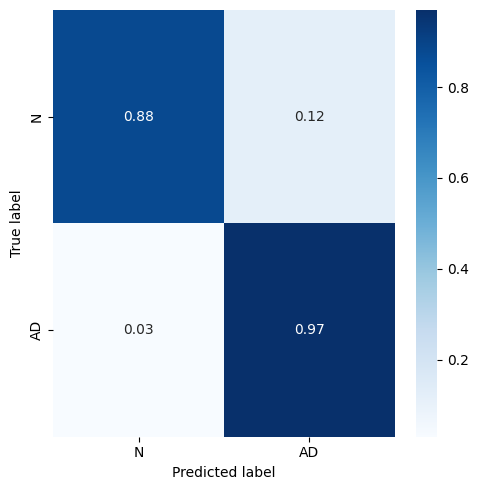

In [11]:
# # create confusion matrix
# if False and __name__ == '__main__':
import pandas as pd
import seaborn
y_pred = np.argmax(model.predict(x_data_test), axis=-1)
con_mat = tf.math.confusion_matrix(labels = y_data_test, predictions = y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis = 1)[:, np.newaxis], decimals = 2)
classes = ['N', 'AD']
con_mat_df = pd.DataFrame(con_mat_norm, index = classes, columns = classes)
figure = plt.figure(figsize = (5, 5))
seaborn.heatmap(con_mat_df, annot = True, cmap = plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig(working_dir + '/confusion_matrix.eps', format='eps')
plt.show()

# Without RPCA (PCA only)

In [12]:

"""---
**Start of actual program blocks:**
"""

# create dataset, create model, train and test
# if __name__ == '__main__':
dense1 = 0
lstm1 = 8
lstm2 = 8
lstm3 = 0

window = 512
overlap = window // 2
oversample = True
decimation = 0
pca = True  # compute PCA on full data matrix
rpca = False  # compute RPCA before PCA
spikes = 1/500
rpca_mu = 0.1

subjs_train_perm = ( (tuple(i for i in range(2, 10)) + tuple(i for i in range(20, 32)), ()), )
# subjs_train_perm = ( (tuple(i for i in range(2, 15)) + tuple(i for i in range(18, 35)), ()), )
subjs_test = (0, 1, 15, 16, 17)  # 2 for N, 3 for AD
epochs = 20

  # if decimation:
  #   window //= decimation
  #   overlap //= decimation

x_data, y_data, subj_inputs = create_dataset(window, overlap, decimation)



(('01', 'N'), ('02', 'N'), ('03', 'N'), ('04', 'N'), ('05', 'N'), ('06', 'N'), ('07', 'N'), ('08', 'N'), ('09', 'N'), ('10', 'N'), ('11', 'N'), ('12', 'N'), ('13', 'N'), ('14', 'N'), ('15', 'N'), ('01', 'AD'), ('02', 'AD'), ('03', 'AD'), ('04', 'AD'), ('05', 'AD'), ('06', 'AD'), ('07', 'AD'), ('08', 'AD'), ('09', 'AD'), ('10', 'AD'), ('11', 'AD'), ('12', 'AD'), ('13', 'AD'), ('14', 'AD'), ('15', 'AD'), ('16', 'AD'), ('17', 'AD'), ('18', 'AD'), ('19', 'AD'), ('20', 'AD'))

### creating dataset

tot samples: 5954304
x_data: (23214, 512, 16)
y_data: (23214, 1)
windows per subject: [433, 379, 369, 779, 569, 454, 627, 939, 780, 567, 564, 543, 554, 748, 642, 691, 714, 719, 762, 664, 745, 786, 830, 673, 735, 797, 571, 560, 769, 717, 663, 771, 576, 581, 943]
class distribution: [8947, 14267]


In [13]:

model, x_data_test, y_data_test, test_acc = train_session(save_model = False, earlystop = 0)  # returned variables can be optionally used by other blocks of code


class distribution (training subset): [5084, 8617]
After oversampling (training subset):
x_data_train: (17234, 512, 16)
y_data_train: (17234, 1)
class distribution: [8617, 8617]

Performing (R)PCA...
PCA truncation 512 -> 50
x_data_train: (12925, 50, 16)
y_data_train: (12925, 1) [6477, 6448]
x_data_val: (4309, 50, 16)
y_data_val: (4309, 1) [2140, 2169]

### creating model


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm1 (LSTM)                         │ (None, 50, 8)               │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop2 (Dropout)                      │ (None, 50, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm2 (LSTM)                         │ (None, 8)                   │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop3 (Dropout)                      │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense2 (Dense)                       │ (None, 2)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,362 (5.32 KB)

 Trainable params: 1,362 (5.32 KB)

 Non-trainable params: 0 (0.00 B)


### training with (2, 3, 4, 5, 6, 7, 8, 9, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31), 12925 inputs, 4309 validation
Epoch 1/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.6423 - loss: 0.6252 - val_accuracy: 0.8582 - val_loss: 0.3566
Epoch 2/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.8668 - loss: 0.3315 - val_accuracy: 0.9139 - val_loss: 0.2295
Epoch 3/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.9153 - loss: 0.2298 - val_accuracy: 0.9378 - val_loss: 0.1743
Epoch 4/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9383 - loss: 0.1812 - val_accuracy: 0.9515 - val_loss: 0.1464
Epoch 5/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.9490 - loss: 0.1520 - val_accuracy: 0.9615 - val_loss: 0.1221
Epoch 6/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9574 - loss: 0.1323 - val_accuracy: 0.9624 - val_loss: 0.1115
Epoch 7/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.9630 - loss: 0.1141 - val_acc

In [14]:
# model test only
# if False and __name__ == '__main__':
print(f'### testing with {len(x_data_test)} inputs')
eval_metrics = model.evaluate(x_data_test, y_data_test)


### testing with 2936 inputs
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9286 - loss: 0.2470


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


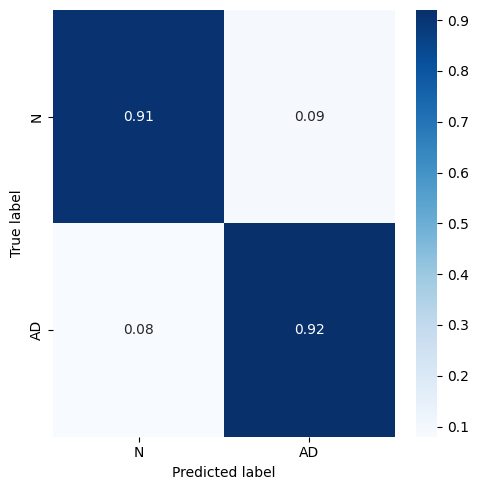

In [15]:
# # create confusion matrix
# if False and __name__ == '__main__':
import pandas as pd
import seaborn
y_pred = np.argmax(model.predict(x_data_test), axis=-1)
con_mat = tf.math.confusion_matrix(labels = y_data_test, predictions = y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis = 1)[:, np.newaxis], decimals = 2)
classes = ['N', 'AD']
con_mat_df = pd.DataFrame(con_mat_norm, index = classes, columns = classes)
figure = plt.figure(figsize = (5, 5))
seaborn.heatmap(con_mat_df, annot = True, cmap = plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig(working_dir + '/confusion_matrix_withoutRPCA.eps', format='eps')
plt.show()